In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
# import seaborn as sns
# from pysal.model import spreg
# from pysal.lib import weights
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:
philly_bbox = (-75.2803, 39.8718, -74.9558, 40.1376)
def convert_to_lat(lat_str):
    lat_parts = lat_str.split(':')
    lat_deg, lat_min = lat_parts[0].split(' ')
    lat_sec = float(lat_parts[1])
    lat_deg = float(lat_deg)
    lat_min = float(lat_min)
    lat_decimal = lat_deg + (lat_min / 60.0) + (lat_sec / 3600.0)
    return lat_decimal if lat_deg >= 0 else -lat_decimal

def convert_to_long(long_str):
    long_parts = long_str.split(':')
    long_deg, long_min = long_parts[0].split(' ')
    long_sec = -float(long_parts[1])
    long_deg = -float(long_deg)
    long_min = -float(long_min)
    lat_decimal = long_deg + (long_min / 60.0) + (long_sec / 3600.0)
    return lat_decimal


/var/folders/l6/_r0p26sx1v9g85my00m5jmgm0000gn/T/ipykernel_74516/1660960789.py:1: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_general = pd.read_csv('APAC_2023_Datasets/Crashes/crash_info_general.csv')
/Users/michael/miniforge3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


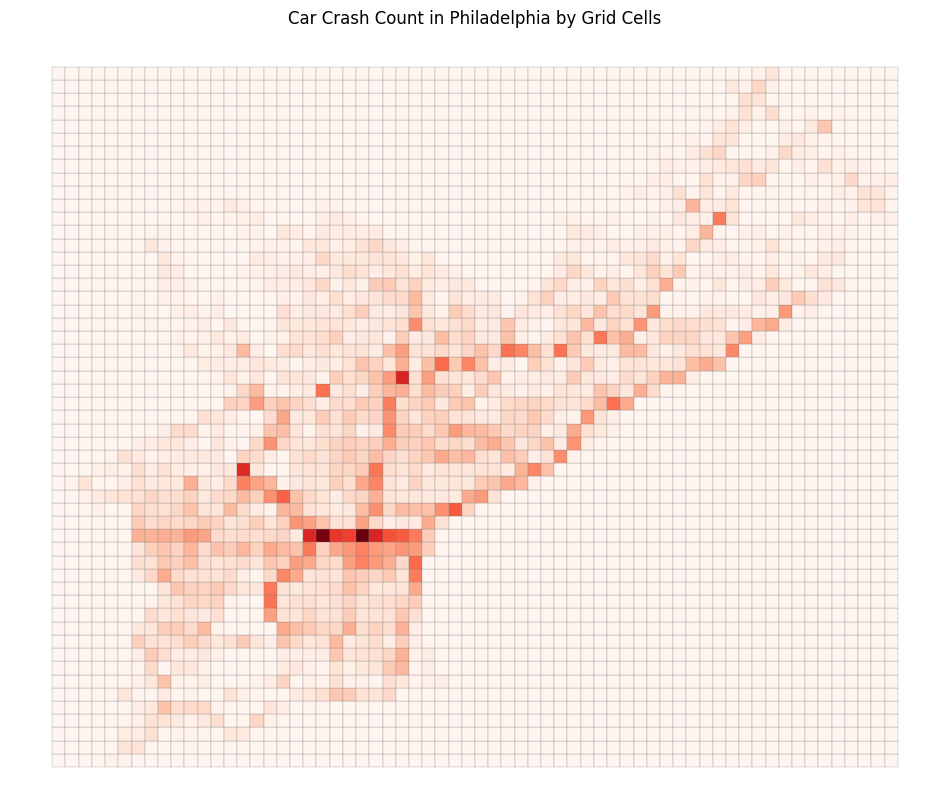

In [3]:
crash_general = pd.read_csv('APAC_2023_Datasets/Crashes/crash_info_general.csv')
crash_general = crash_general[crash_general['LATITUDE'].notna() & crash_general['LONGITUDE'].notna()]
crash_general['LATITUDE'] = crash_general['LATITUDE'].apply(convert_to_lat)
crash_general['LONGITUDE'] = crash_general['LONGITUDE'].apply(convert_to_long)
cell_size = 0.005  # in
x_min, y_min, x_max, y_max = philly_bbox
n_cells_x = int((x_max - x_min) / cell_size)
n_cells_y = int((y_max - y_min) / cell_size)
grid_cells = []
for x in range(n_cells_x):
    for y in range(n_cells_y):
        grid_cell = Polygon([(x_min + x * cell_size, y_min + y * cell_size),
                             (x_min + (x+1) * cell_size, y_min + y * cell_size),
                             (x_min + (x+1) * cell_size, y_min + (y+1) * cell_size),
                             (x_min + x * cell_size, y_min + (y+1) * cell_size)])
        grid_cells.append(grid_cell)

grid = gpd.GeoDataFrame({'geometry': grid_cells, 'index': range(len(grid_cells))})

crash_points = gpd.points_from_xy(crash_general.LONGITUDE, crash_general.LATITUDE)
crash_gdf = gpd.GeoDataFrame(geometry=crash_points)
crash_counts = gpd.sjoin(grid, crash_gdf, op='contains').groupby(level=0).size().reset_index(name='count')
# if grid cell does not contain any crash, set the count to 0
crash_counts = crash_counts.set_index('index').reindex(range(len(grid_cells))).fillna(0).reset_index()
ax = grid.plot(column=crash_counts['count'], cmap='Reds', figsize=(12, 12), edgecolor='gray', linewidth=0.2)
ax.set_title('Car Crash Count in Philadelphia by Grid Cells')
ax.set_axis_off()
plt.show()


/var/folders/l6/_r0p26sx1v9g85my00m5jmgm0000gn/T/ipykernel_74516/221198162.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  crash_counts = gpd.sjoin(census, crash_gdf, predicate='contains').groupby(level=0).size().reset_index(name='count')


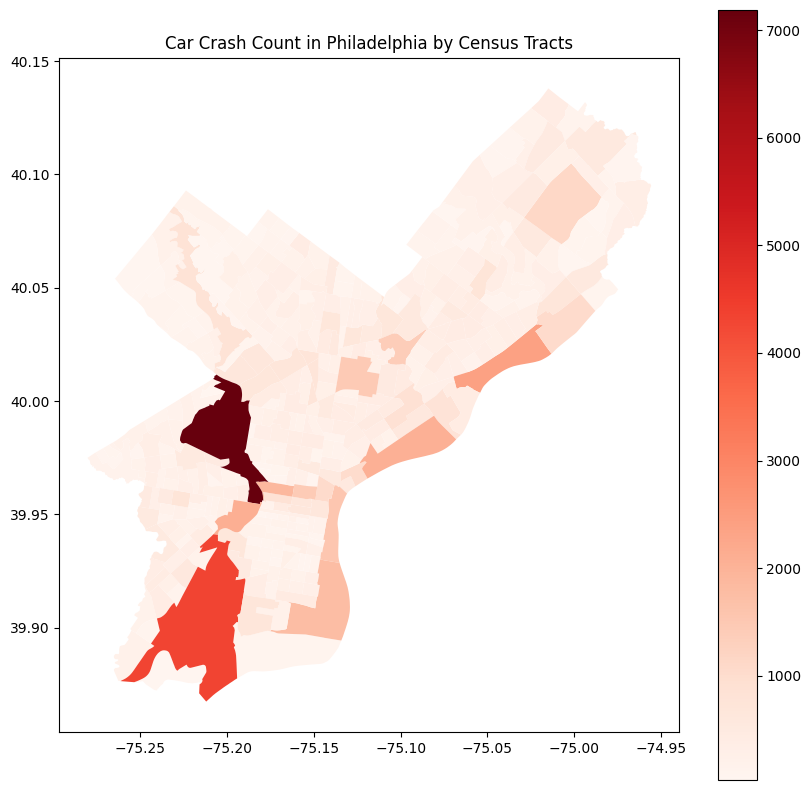

In [5]:
# count the car crashes in each census tract
census = gpd.read_file('Data/Census_Tracts_2010-shp/c16590ca-5adf-4332-aaec-9323b2fa7e7d2020328-1-1jurugw.pr6w.shp')
crash_counts = gpd.sjoin(census, crash_gdf, predicate='contains').groupby(level=0).size().reset_index(name='count')
# if census tract does not contain any crash, set the count to 0
crash_counts = crash_counts.set_index('index').reindex(range(len(census))).fillna(0).reset_index()
fig, ax = plt.subplots(figsize=(10,10))
census.plot(column=crash_counts['count'], cmap='Reds', legend=True, ax=ax)
ax.set_title('Car Crash Count in Philadelphia by Census Tracts')
plt.show()


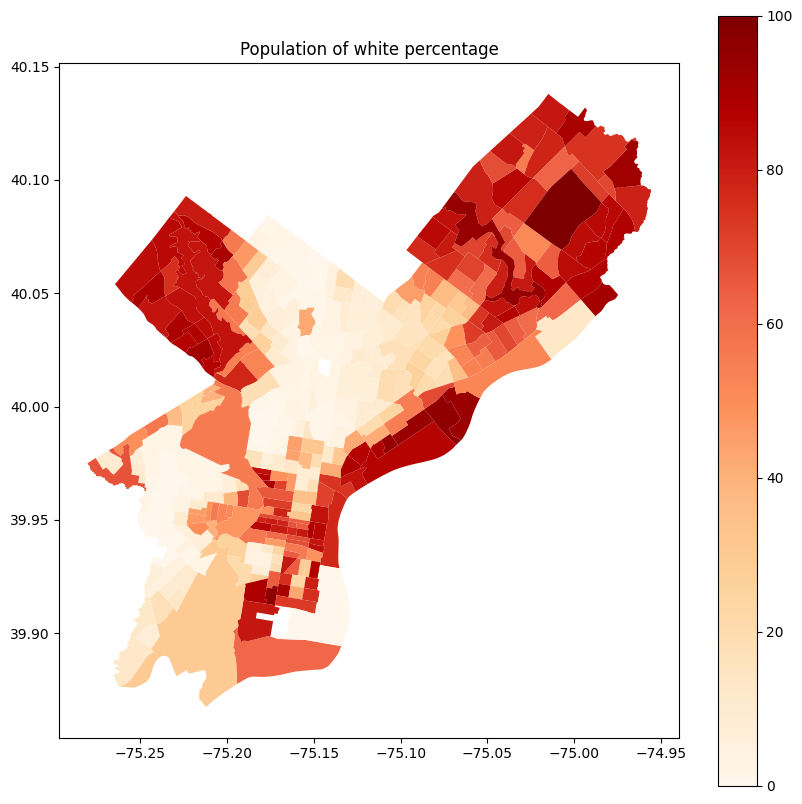

In [14]:
# in each grid, extract the other features tha may be related to the crash count
# e.g. population, income, etc.
populations = pd.read_csv('APAC_2023_Datasets/Traffic, Investigations _ Other/philadelphia_population_metrics.csv')
census['GEOID10'] = census['GEOID10'].astype(int)
populations = populations.merge(census[['GEOID10', 'geometry']], how='left', left_on='GEOGRAPHY_NAME', right_on='GEOID10')
populations = gpd.GeoDataFrame(populations)
fig6, ax = plt.subplots(figsize=(10,10))
populations.plot(column='PERCENT_WHITE_NH', cmap='OrRd', legend=True, ax=ax)
ax.set_title('Population of white percentage')
plt.show()

/var/folders/l6/_r0p26sx1v9g85my00m5jmgm0000gn/T/ipykernel_74516/2607775344.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  crime_count = gpd.sjoin(census, crime, predicate='contains').groupby(level=0).size().reset_index(name='count')


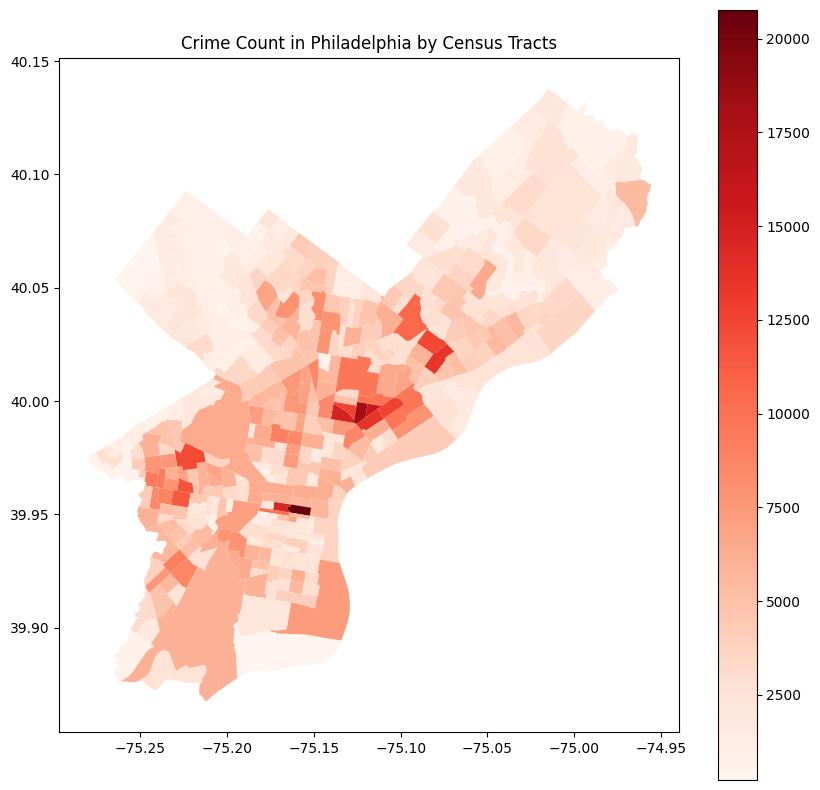

In [8]:

crime = pd.read_csv('APAC_2023_Datasets/Traffic, Investigations _ Other/crimes.csv')
crime = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.lng, crime.lat))
crime_count = gpd.sjoin(census, crime, predicate='contains').groupby(level=0).size().reset_index(name='count')
crime_count = crime_count.set_index('index').reindex(range(len(census))).fillna(0).reset_index()
fig7, ax = plt.subplots(figsize=(10,10))
census.plot(column=crime_count['count'], cmap='Reds', legend=True, ax=ax)
ax.set_title('Crime Count in Philadelphia by Census Tracts')
plt.show()



In [9]:
# now we have car crash count, population, crime count in each census tract
# we can use these featrues to train a model to predict the car crash count in each census tract
# merge the features into one geodataframe

data = gpd.GeoDataFrame(geometry=census['geometry'])
data['crash_count'] = crash_counts['count']
data['crime'] = crime_count['count'] # normalize count
data['crime'] = data['crime'] / data['crime'].max()
data['black_percentage'] = populations['PERCENT_BLACK_NH']
data['asian_percentage'] = populations['PERCENT_ASIAN_NH']
data['hispanic_percentage'] = populations['PERCENT_HISPANIC']


In [10]:
y = data['crash_count'].values
X = data.drop(['crash_count', 'geometry'], axis=1).values

# Queen contiguity
w_queen = weights.contiguity.Queen.from_dataframe(data)

# K-nearest neighbors
k = 4  # Choose the number of nearest neighbors
w_knn = weights.distance.KNN.from_dataframe(data, k=k)

# Spatial Poisson model using the queen contiguity weights matrix
spatial_poisson_queen = spreg.GM_Lag(y, X, w=w_queen, family='poisson', name_y='crash_count', name_x=['crime', 'black_percentage', 'asian_percentage', 'hispanic_percentage'])

# Spatial Poisson model using the k-nearest neighbors weights matrix
spatial_poisson_knn = spreg.GM_Lag(y, X, w=w_knn, family='poisson', name_y='crash_count', name_x=['crime', 'black_percentage', 'asian_percentage', 'hispanic_percentage'])

# Print the results for the queen contiguity weights matrix
print(spatial_poisson_queen.summary)

# Print the results for the k-nearest neighbors weights matrix
print(spatial_poisson_knn.summary)




NameError: name 'weights' is not defined